In [1]:
import sys
sys.path.append('../')
sys.path.append('../data')
sys.path.append('../script')

from src.dataset import Dataset
from src.model import WrapHookedTransformer

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from functools import partial
import math

import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

%load_ext autoreload
%autoreload 2


/home/fortu/miniconda3/envs/mpi/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Variance in the dataset

In [2]:
dataset = Dataset("../data/dataset_gpt2.json")
model = WrapHookedTransformer.from_pretrained("gpt2")

Using pad_token, but it is not set yet.


Loaded pretrained model gpt2 into HookedTransformer


In [12]:
filter_value = (0.2,0.25)

dataset = Dataset("../data/dataset_gpt2.json")
dataset.print_statistics()
dataset.filter(filter_key = "mem", filter_interval=filter_value)
dataset.filter(filter_key = "cp", filter_interval=filter_value)
dataset.print_statistics()
dataset.random_sample(10, 15)

----------------------------
Memorizing win number of examples: 9916
Copying win number of examples: 317935
Mean of of memorized token probs in memorizing win: tensor(0.1106)
Mean of of memorized token probs in copying win: tensor(0.0018)
Mean of of orthogonal token probs in copying win: tensor(0.6024)
Mean of of orthogonal token probs in memorizing win: tensor(0.0205)
----------------------------
Memorizing win number of examples: 545
Copying win number of examples: 12583
Mean of of memorized token probs in memorizing win: tensor(0.2211)
Mean of of memorized token probs in copying win: tensor(0.0049)
Mean of of orthogonal token probs in copying win: tensor(0.2244)
Mean of of orthogonal token probs in memorizing win: tensor(0.0390)
possible_lengths for sampling 10: [12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0]


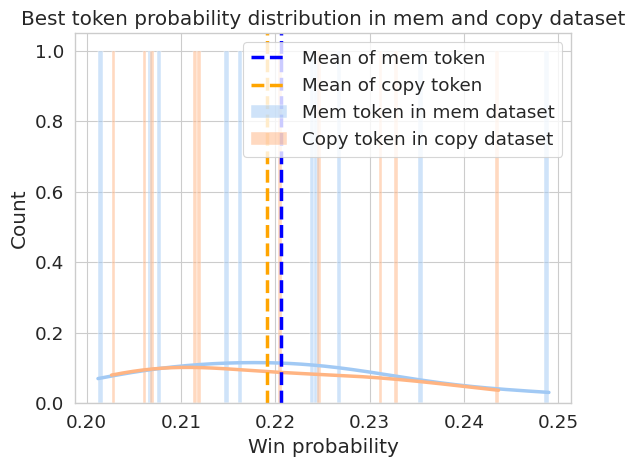

In [13]:
target_win_prob = [d["target_probs"] for d in dataset.pos_dataset]
orthogonal_win_prob = [d["orthogonal_probs"] for d in dataset.neg_dataset]

# Plot
sns.set_style("whitegrid")
sns.set_palette("pastel")
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.histplot(target_win_prob, bins=100, label="Mem token in mem dataset", kde=True)
sns.histplot(orthogonal_win_prob, bins=100, label="Copy token in copy dataset", kde=True)
#plot mean of target_win_prob
plt.axvline(x=sum(target_win_prob)/len(target_win_prob), color="blue", linestyle="--", label="Mean of mem token")
#plot mean of orthogonal_win_prob
plt.axvline(x=sum(orthogonal_win_prob)/len(orthogonal_win_prob), color="orange", linestyle="--", label="Mean of copy token")
plt.xlabel("Win probability")
plt.ylabel("Count")
plt.legend()
plt.title("Best token probability distribution in mem and copy dataset")
plt.show()

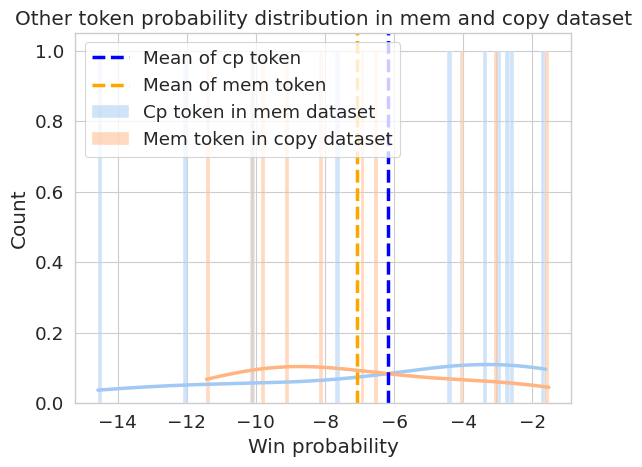

In [14]:

target_win_prob_orthogonal = [ math.log(d["orthogonal_probs"]) for d in dataset.pos_dataset]
orthogonal_win_prob_target = [ math.log(d["target_probs"]) for d in dataset.neg_dataset]

# Plot
sns.set_style("whitegrid")
sns.set_palette("pastel")
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.histplot(target_win_prob_orthogonal, bins=100, label="Cp token in mem dataset", kde=True)
sns.histplot(orthogonal_win_prob_target, bins=100, label="Mem token in copy dataset", kde=True)
#plot mean of target_win_prob
plt.axvline(x=sum(target_win_prob_orthogonal)/len(target_win_prob_orthogonal), color="blue", linestyle="--", label="Mean of cp token")
#plot mean of orthogonal_win_prob
plt.axvline(x=sum(orthogonal_win_prob_target)/len(orthogonal_win_prob_target), color="orange", linestyle="--", label="Mean of mem token")
plt.xlabel("Win probability")
plt.ylabel("Count")
plt.legend()
plt.title("Other token probability distribution in mem and copy dataset")
plt.show()

## Variance in the logits

In [15]:
pos_logits, pos_clean_cache = model.run_with_cache([d["premise"] for d in dataset.pos_dataset])
neg_logits, neg_clean_cache = model.run_with_cache([d["premise"] for d in dataset.neg_dataset])

In [16]:
pos_probs = torch.log_softmax(pos_logits, dim=-1)[:,-1,:]
neg_probs = torch.log_softmax(neg_logits, dim=-1)[:, -1, :]

pos_target_ids = {
    "target": model.to_tokens([d["target"] for d in dataset.pos_dataset], prepend_bos=False),
    "orthogonal": model.to_tokens([d["orthogonal_token"] for d in dataset.pos_dataset], prepend_bos=False),
}
neg_target_ids = {
    "target": model.to_tokens([d["target"] for d in dataset.neg_dataset], prepend_bos=False),
    "orthogonal": model.to_tokens([d["orthogonal_token"] for d in dataset.neg_dataset], prepend_bos=False),
}


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


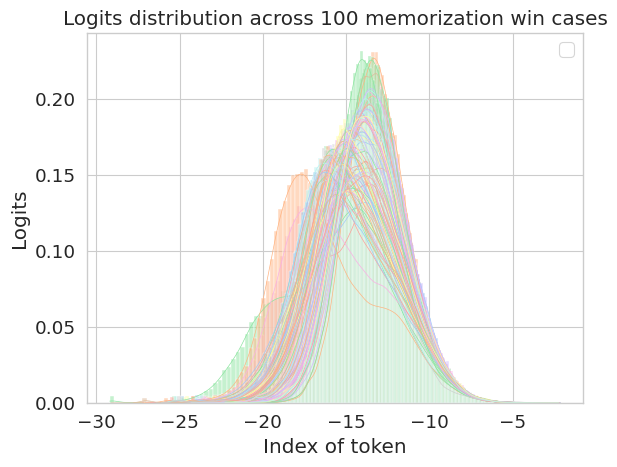

In [30]:
#plot all 100 distribution of logits in the same plot as a line plot
sns.set_style("whitegrid")
sns.set_palette("pastel")
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})
for i in range(100):
    #his plot with just the line
    sns.histplot(pos_probs[i].detach().numpy(), bins=100, kde=True, stat="density", line_kws={'linewidth':0.5})
    
plt.xlabel("Index of token")
plt.ylabel("Logits")
plt.title("Logits distribution across 100 memorization win cases")
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


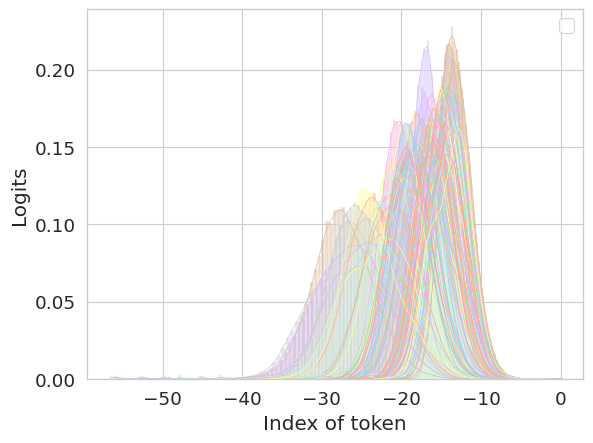

In [67]:
sns.set_style("whitegrid")
sns.set_palette("pastel")
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})
for i in range(100):
    #his plot with just the line
    sns.histplot(neg_probs[i].detach().numpy(), bins=100, kde=True, stat="density", line_kws={'linewidth':0.5})
    
plt.xlabel("Index of token")
plt.ylabel("Logits")
plt.title("Logits distribution across 100 copy win cases")
plt.legend()

Text(0.5, 1.0, 'Logprob distribution of best token in mem and cp dataset (100 examples each)')

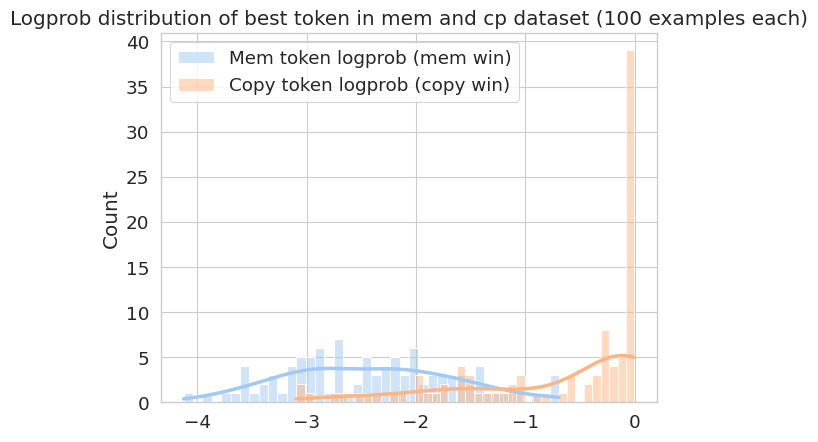

In [444]:
#extract the logprob for the target token and orthogonal token
pos_target_logprob = pos_probs.gather(-1, index=pos_target_ids["target"]).squeeze(-1)
neg_orthogonal_logprob = neg_probs.gather(-1, index=neg_target_ids["orthogonal"]).squeeze(-1)

#plot the distribution of logprob for target token and orthogonal token
sns.set_style("whitegrid")
sns.set_palette("pastel")
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.histplot(pos_target_logprob.detach().numpy(), bins=40, label="Mem token logprob (mem win)", kde=True)
sns.histplot(neg_orthogonal_logprob.detach().numpy(), bins=40, label="Copy token logprob (copy win)", kde=True)
plt.legend()
plt.title("Logprob distribution of best token in mem and cp dataset (100 examples each)")
#plot mean of target_win_pro

### Corrupted data

In [76]:
# add noise
pos_input_emb_corrupted = dataset.add_noise(
    model,
    [d["premise"] for d in dataset.pos_dataset],
    noise_index=[1,2,3],
    target_win=8,
    noise_mlt=3
)
neg_input_emb_corrupted = dataset.add_noise(
    model,
    [d["premise"] for d in dataset.neg_dataset],
    noise_index=[1, 2, 3, 8, 9, 10, 11],
    target_win=8,
    noise_mlt=2
)

pos_corrupted_logit, pos_corrupted_cache = model.run_with_cache_from_embed(pos_input_emb_corrupted)
neg_corrupted_logit, neg_corrupted_cache = model.run_with_cache_from_embed(neg_input_emb_corrupted)

# plot distribution of corrupted logits
pos_corrupted_probs = torch.log_softmax(pos_corrupted_logit, dim=-1)[:,-1,:]
neg_corrupted_probs = torch.log_softmax(neg_corrupted_logit, dim=-1)[:, -1, :]
pos_corrupted_probs_mean = pos_corrupted_probs.mean(dim=-1)
neg_corrupted_probs_mean = neg_corrupted_probs.mean(dim=-1)

Text(0.5, 1.0, 'Corrupted Logprob distribution of best token in mem and copy dataset')

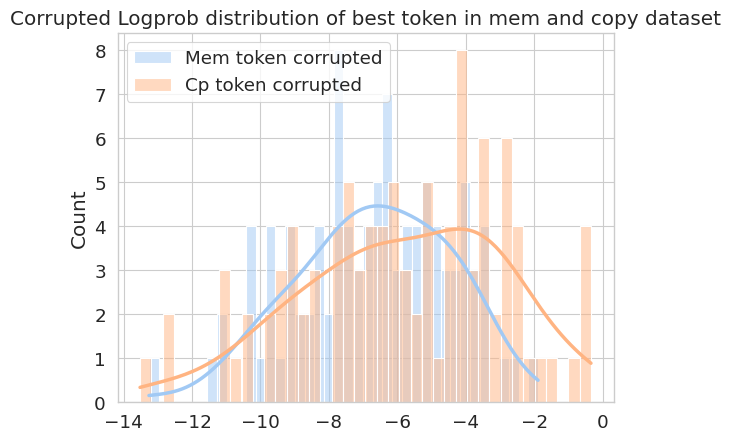

In [338]:
#extract the logprob for the target token and orthogonal token
pos_target_corrupted_logprob = pos_corrupted_probs.gather(-1, index=pos_target_ids["target"]).squeeze(-1)
neg_target_corrupted_logprob = neg_corrupted_probs.gather(-1, index=neg_target_ids["orthogonal"]).squeeze(-1)

#plot the distribution of logprob for target token and orthogonal token
sns.set_style("whitegrid")
sns.set_palette("pastel")
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.histplot(pos_target_corrupted_logprob.detach().numpy(), bins=40, label="Mem token corrupted", kde=True)
sns.histplot(neg_target_corrupted_logprob.detach().numpy(), bins=40, label="Cp token corrupted", kde=True)
plt.legend()
plt.title("Corrupted Logprob distribution of best token in mem and copy dataset")
#plot mean of target_win_pro

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


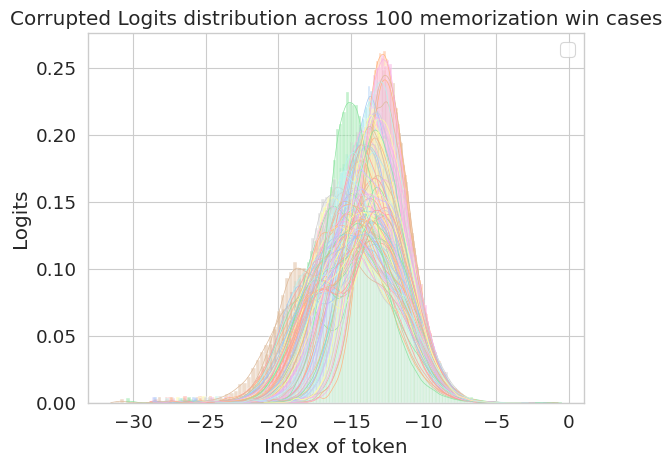

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


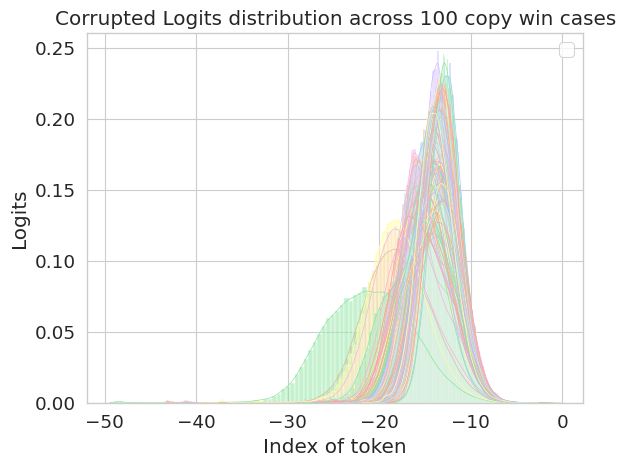

In [32]:


sns.set_style("whitegrid")
sns.set_palette("pastel")
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})
for i in range(100):
    #his plot with just the line
    sns.histplot(pos_corrupted_probs[i].detach().numpy(), bins=100, kde=True, stat="density", line_kws={'linewidth':0.5})
    
plt.xlabel("Index of token")
plt.ylabel("Logits")
plt.legend()
plt.title("Corrupted Logits distribution across 100 memorization win cases")
plt.show()

sns.set_style("whitegrid")
sns.set_palette("pastel")
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})
for i in range(100):
    #his plot with just the line
    sns.histplot(neg_corrupted_probs[i].detach().numpy(), bins=100, kde=True, stat="density", line_kws={'linewidth':0.5})
    
plt.xlabel("Index of token")
plt.ylabel("Logits")
plt.title("Corrupted Logits distribution across 100 copy win cases")
plt.legend()
plt.show()

## Variance in the patched for positive example

Compare the patched logit with the original logit and the corrupted logit of the tarrget token

In [25]:
import scipy

In [24]:
def indirect_effect(logits, corrupted_logits, first_ids_pos):
    logits = torch.nn.functional.softmax(logits, dim=-1)
    corrupted_logits = torch.nn.functional.softmax(corrupted_logits, dim=-1)
    # Use torch.gather to get the desired values
    logits_values = torch.gather(logits[:, -1, :], 1, first_ids_pos).squeeze()
    corrupted_logits_values = torch.gather(
        corrupted_logits[:, -1, :], 1, first_ids_pos
    ).squeeze()

    delta_value = logits_values - corrupted_logits_values
    ttest = scipy.ttest_1samp(delta_value.cpu().detach().numpy(), 0)
    return {
        "mean": delta_value.mean(),
        "std": delta_value.std(),
        "t-value": torch.tensor(ttest[0], device=delta_value.device),
        "p-value": torch.tensor(ttest[1], device=delta_value.device),
        "full_delta": delta_value,
    }

In [26]:
LAYER = 11
POS = 14

# add noise
pos_input_emb_corrupted = dataset.add_noise(
    model,
    [d["premise"] for d in dataset.pos_dataset],
    noise_index=[1,2,3,9,10,11],
    target_win=8,
    noise_mlt=1.4 
)

import transformer_lens.utils as utils
def patch_mlp(activation, hook, clean_activation, pos):
    activation[:,pos,:] = clean_activation[:,pos,:]
    return activation
def patch_attn_output(activation, hook, clean_activation, pos):
    activation[:,pos,:] = clean_activation[:,pos,:]
    return activation
def embed_hook(cache, hook, input_embeddings):
    cache[:,:,:] = input_embeddings
    return cache

# hook_fn = partial(patch_mlp, clean_activation=pos_clean_cache[utils.get_act_name("mlp_out",LAYER)], pos=POS)
hook_fn = partial(patch_mlp, clean_activation=pos_clean_cache[utils.get_act_name("attn_out",LAYER)], pos=POS)
hook_embed = partial(embed_hook, input_embeddings=pos_input_emb_corrupted)

pos_patched_logit_significant = model.run_with_hooks([d["premise"] for d in dataset.pos_dataset],
                     fwd_hooks=[(utils.get_act_name("mlp_out",LAYER), hook_fn), ("hook_embed", hook_embed)])


hook_fn = partial(patch_mlp, clean_activation=pos_clean_cache[utils.get_act_name("mlp_out",LAYER)], pos=6)

pos_patched_logit_non_significant = model.run_with_hooks([d["premise"] for d in dataset.pos_dataset],
                     fwd_hooks=[(utils.get_act_name("mlp_out",LAYER), hook_fn), ("hook_embed", hook_embed)])



pos_patched_logprob_significant = torch.softmax(pos_patched_logit_significant, dim=-1)[:, -1, :]
pos_patched_logit_non_significant = torch.softmax(pos_patched_logit_non_significant, dim=-1)[:, -1, :]
pos_clean_logprob = torch.softmax(
    model([d["premise"] for d in dataset.pos_dataset]), dim=-1
)[:, -1, :]
pos_corrupted_logprobs = torch.softmax(
    model.run_with_hooks(
        [d["premise"] for d in dataset.pos_dataset],
        fwd_hooks=[("hook_embed", hook_embed)],
    ), dim=-1
)[:,-1,:]
pos_corrupted_logprobs_target = pos_corrupted_logprobs.gather(-1, index=pos_target_ids["target"]).squeeze(-1)
print("pos_corrupted_logprobs_target", pos_corrupted_logprobs_target)
pos_patched_logprob_target_significant = pos_patched_logprob_significant.gather(-1, index=pos_target_ids["target"]).squeeze(-1)
pos_patched_logit_non_significant = pos_patched_logit_non_significant.gather(-1, index=pos_target_ids["target"]).squeeze(-1)
pos_clean_logprob_target = pos_clean_logprob.gather(-1, index=pos_target_ids["target"]).squeeze(-1)
print("pos_clean_logprog_target", pos_clean_logprob_target)
# plot the distribution of logprob for target token and orthogonal token

print((pos_clean_logprob_target - pos_corrupted_logprobs_target).mean())

sns.set_style("whitegrid")
sns.set_palette("pastel")
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})
# increase the size of the plot
plt.figure(figsize=(15, 10))
sns.histplot(
    pos_patched_logprob_target_significant.detach().numpy(), bins=40, label="Patched significant", kde=True
)

sns.histplot(pos_corrupted_logprobs_target.detach().numpy(), bins=40, label="Corrupted", kde=True)
sns.histplot(    pos_clean_logprob_target.detach().numpy(), bins=40, label="Clean", kde=True)
#plot the mean of target_win_prob
plt.axvline(x=pos_patched_logprob_target_significant.detach().numpy().mean(), color="blue", linestyle="--", label="Mean of patched significant")
plt.axvline(x=sum(pos_corrupted_logprobs_target.detach().numpy())/len(pos_corrupted_logprobs_target.detach().numpy()), color="orange", linestyle="--", label="Mean of corrupted")
plt.axvline(x=sum(pos_clean_logprob_target.detach().numpy())/len(pos_clean_logprob_target.detach().numpy()), color="green", linestyle="--", label="Mean of clean")
#plot std deviation in grey area for pos_patched_logprob_target_significant
# plt.axvspan(sum(pos_patched_logprob_target_significant.detach().numpy())/len(pos_patched_logprob_target_significant.detach().numpy())-pos_patched_logprob_target_significant.std().detach().numpy(), sum(pos_patched_logprob_target_significant.detach().numpy())/len(pos_patched_logprob_target_significant.detach().numpy())+pos_patched_logprob_target_significant.std().detach().numpy(), alpha=0.5, color='grey')
# plot median absolut deviation
mad = torch.median(torch.abs(pos_patched_logprob_target_significant - torch.median(pos_patched_logprob_target_significant))) 
# plt.axvspan(sum(pos_patched_logprob_target_significant.detach().numpy())/len(pos_patched_logprob_target_significant.detach().numpy())-mad.detach().numpy(), sum(pos_patched_logprob_target_significant.detach().numpy())/len(pos_patched_logprob_target_significant.detach().numpy())+mad.detach().numpy(), alpha=0.5, color='grey')

sns.histplot()
plt.legend()
plt.show()
sns.set_style("whitegrid")
sns.set_palette("pastel")
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.histplot(pos_patched_logit_non_significant.detach().numpy(), bins=40, label="Patched non-significant", kde=True)

IndexError: too many indices for tensor of dimension 2

In [23]:
pos_target_ids["target"]

tensor([[46950],
        [ 3576],
        [20059],
        [19339],
        [19339],
        [28190],
        [19339],
        [46950],
        [20059],
        [19339]])

In [37]:
from scipy.stats import ttest_ind, wilcoxon
print(ttest_ind(pos_patched_logit_non_significant.detach().numpy(), pos_corrupted_logprobs_target.detach().numpy()))
print(ttest_ind(pos_patched_logprob_target_significant.detach().numpy(), pos_corrupted_logprobs_target.detach().numpy()))

TtestResult(statistic=0.0, pvalue=1.0, df=198.0)
TtestResult(statistic=3.5630332814414585, pvalue=0.0004593265027685578, df=198.0)


In [10]:
#print all the variance
print("Variance of patched significant: ", pos_patched_logprob_target_significant.var().detach().numpy())
print("Variance of patched non-significant: ", pos_patched_logit_non_significant.var().detach().numpy())
print("Variance of corrupted: ", pos_corrupted_logprobs_target.var().detach().numpy())
print("Variance of clean: ", pos_clean_logprob_target.var().detach().numpy())

Variance of patched significant:  0.012128944
Variance of patched non-significant:  0.0049037174
Variance of corrupted:  0.0049037174
Variance of clean:  0.00019880573


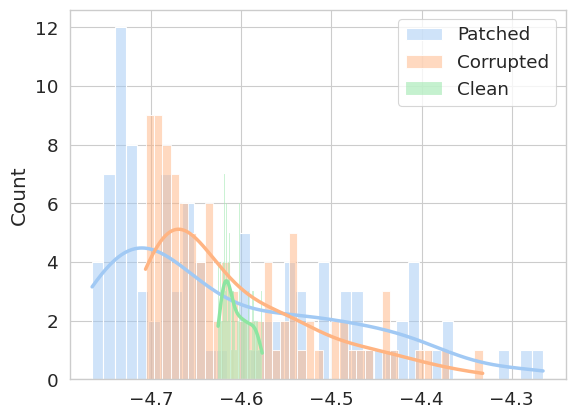

In [51]:
# plot the distribution of logprob for target token and orthogonal token
sns.set_style("whitegrid")
sns.set_palette("pastel")
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.histplot(torch.log_softmax(pos_patched_logprob_target_significant, dim=0).detach().numpy(), bins=40, label="Patched", kde=True)
sns.histplot(torch.log_softmax(pos_corrupted_logprobs_target, dim=0).detach().numpy(), bins=40, label="Corrupted", kde=True)
sns.histplot(torch.log_softmax(pos_clean_logprob_target, dim=0).detach().numpy(), bins=40, label="Clean", kde=True)

sns.histplot()
plt.legend()

In [10]:
pos_input_emb_corrupted = dataset.add_noise(
    model,
    [d["premise"] for d in dataset.pos_dataset],
    noise_index=[1,2,3,9,10,11],
    target_win=8,
    noise_mlt=1.4 
)
pos_input_emb_corrupted

CORRUPTED EMBEDDINGS tensor([[[ 0.0517, -0.0274,  0.0502,  ...,  0.0074,  0.1555,  0.1210],
         [ 0.0737, -0.2232,  0.3628,  ..., -0.1296, -0.0028,  0.2212],
         [-0.0999, -0.1711,  0.0073,  ...,  0.0153,  0.1149, -0.1648],
         ...,
         [-0.0078,  0.0120,  0.0575,  ...,  0.1164, -0.0361, -0.0234],
         [ 0.0109,  0.0916, -0.0165,  ...,  0.1307, -0.0693, -0.0087],
         [ 0.0054,  0.0280,  0.0378,  ..., -0.0654, -0.0143,  0.1055]],

        [[ 0.0517, -0.0274,  0.0502,  ...,  0.0074,  0.1555,  0.1210],
         [-0.2437, -0.1405,  0.3489,  ..., -0.2458, -0.3525, -0.0754],
         [-0.0012, -0.0159,  0.0006,  ...,  0.1671, -0.0713,  0.1247],
         ...,
         [-0.0078,  0.0120,  0.0575,  ...,  0.1164, -0.0361, -0.0234],
         [-0.0280,  0.1024,  0.0349,  ...,  0.0308, -0.0989, -0.0196],
         [-0.0317,  0.0128,  0.0314,  ...,  0.1126, -0.0114, -0.0508]],

        [[ 0.0517, -0.0274,  0.0502,  ...,  0.0074,  0.1555,  0.1210],
         [-0.0178,  0.11

tensor([[[ 0.0517, -0.0274,  0.0502,  ...,  0.0074,  0.1555,  0.1210],
         [ 0.0737, -0.2232,  0.3628,  ..., -0.1296, -0.0028,  0.2212],
         [-0.0999, -0.1711,  0.0073,  ...,  0.0153,  0.1149, -0.1648],
         ...,
         [-0.0078,  0.0120,  0.0575,  ...,  0.1164, -0.0361, -0.0234],
         [ 0.0109,  0.0916, -0.0165,  ...,  0.1307, -0.0693, -0.0087],
         [ 0.0054,  0.0280,  0.0378,  ..., -0.0654, -0.0143,  0.1055]],

        [[ 0.0517, -0.0274,  0.0502,  ...,  0.0074,  0.1555,  0.1210],
         [-0.2437, -0.1405,  0.3489,  ..., -0.2458, -0.3525, -0.0754],
         [-0.0012, -0.0159,  0.0006,  ...,  0.1671, -0.0713,  0.1247],
         ...,
         [-0.0078,  0.0120,  0.0575,  ...,  0.1164, -0.0361, -0.0234],
         [-0.0280,  0.1024,  0.0349,  ...,  0.0308, -0.0989, -0.0196],
         [-0.0317,  0.0128,  0.0314,  ...,  0.1126, -0.0114, -0.0508]],

        [[ 0.0517, -0.0274,  0.0502,  ...,  0.0074,  0.1555,  0.1210],
         [-0.0178,  0.1160, -0.1543,  ..., -0

In [19]:
pos_corrupted_logprobs = torch.softmax(
    model.run_with_hooks(
        [d["premise"] for d in dataset.pos_dataset],
        fwd_hooks=[("hook_embed", hook_embed)],
    ), dim=-1
)[:,-1,:]
pos_corrupted_logprobs_target = pos_corrupted_logprobs.gather(-1, index=pos_target_ids["target"]).squeeze(-1)
pos_corrupted_logprobs_target

tensor([3.2625e-02, 1.2935e-01, 3.8613e-02, 4.7530e-02, 2.3086e-01, 1.0797e-01,
        5.4028e-02, 1.2089e-02, 2.6189e-02, 2.9570e-01, 1.5666e-01, 1.9906e-01,
        8.7051e-02, 3.9835e-03, 2.4913e-01, 1.0699e-01, 1.4273e-01, 4.0405e-02,
        3.2270e-03, 5.5594e-02, 1.1975e-01, 1.5637e-01, 8.8340e-03, 4.7548e-02,
        8.2109e-02, 6.0330e-02, 1.2829e-01, 3.9431e-02, 7.7714e-02, 2.8901e-03,
        1.1040e-01, 1.3151e-01, 1.9696e-02, 2.0929e-01, 2.9363e-02, 1.3162e-01,
        8.0080e-02, 1.2157e-01, 8.2534e-03, 1.3608e-02, 1.1703e-01, 7.9559e-03,
        1.4810e-01, 9.9004e-02, 3.8103e-02, 1.0942e-01, 5.0260e-03, 1.2603e-01,
        3.9862e-02, 1.2592e-01, 5.5266e-03, 1.4208e-01, 1.0746e-01, 7.7721e-03,
        7.4024e-02, 3.2955e-02, 4.4642e-02, 4.3002e-03, 1.6509e-01, 5.5674e-02,
        1.3924e-01, 1.8664e-02, 3.5823e-02, 1.7890e-01, 9.9560e-02, 1.3444e-01,
        1.6139e-01, 9.7398e-02, 1.7510e-01, 8.1655e-02, 3.6916e-03, 4.1507e-02,
        5.9428e-02, 3.2501e-02, 1.0763e-

In [20]:
pos_clean_logprob_target

tensor([0.2270, 0.2012, 0.2353, 0.2067, 0.2148, 0.2245, 0.2490, 0.2237, 0.2162,
        0.2076])

In [17]:
pos_corrupted_logprobs_target

tensor([3.2625e-02, 1.2935e-01, 3.8613e-02, 4.7530e-02, 2.3086e-01, 1.0797e-01,
        5.4028e-02, 1.2089e-02, 2.6189e-02, 2.9570e-01, 1.5666e-01, 1.9906e-01,
        8.7051e-02, 3.9835e-03, 2.4913e-01, 1.0699e-01, 1.4273e-01, 4.0405e-02,
        3.2270e-03, 5.5594e-02, 1.1975e-01, 1.5637e-01, 8.8340e-03, 4.7548e-02,
        8.2109e-02, 6.0330e-02, 1.2829e-01, 3.9431e-02, 7.7714e-02, 2.8901e-03,
        1.1040e-01, 1.3151e-01, 1.9696e-02, 2.0929e-01, 2.9363e-02, 1.3162e-01,
        8.0080e-02, 1.2157e-01, 8.2534e-03, 1.3608e-02, 1.1703e-01, 7.9559e-03,
        1.4810e-01, 9.9004e-02, 3.8103e-02, 1.0942e-01, 5.0260e-03, 1.2603e-01,
        3.9862e-02, 1.2592e-01, 5.5266e-03, 1.4208e-01, 1.0746e-01, 7.7721e-03,
        7.4024e-02, 3.2955e-02, 4.4642e-02, 4.3002e-03, 1.6509e-01, 5.5674e-02,
        1.3924e-01, 1.8664e-02, 3.5823e-02, 1.7890e-01, 9.9560e-02, 1.3444e-01,
        1.6139e-01, 9.7398e-02, 1.7510e-01, 8.1655e-02, 3.6916e-03, 4.1507e-02,
        5.9428e-02, 3.2501e-02, 1.0763e-

tensor(0.0583) tensor(0.0791)
tensor(0.1243) tensor(0.0896)


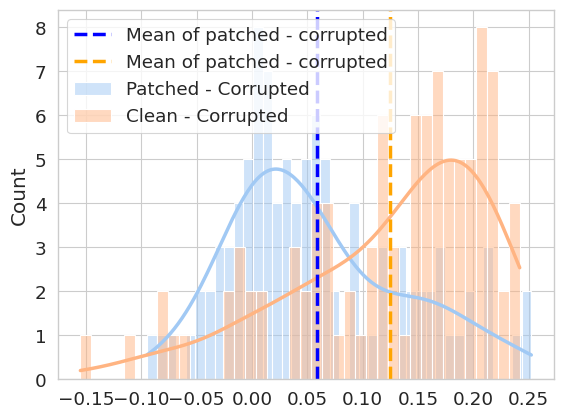

In [52]:



pos_patched_improve = pos_patched_logprob_target_significant - pos_corrupted_logprobs_target
pos_baseline = pos_clean_logprob_target - pos_corrupted_logprobs_target

#plot the distribution of logprob for target token and orthogonal token
sns.set_style("whitegrid")
sns.set_palette("pastel")
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.histplot(pos_patched_improve.detach().numpy(), bins=40, label="Patched - Corrupted", kde=True)
sns.histplot(pos_baseline.detach().numpy(), bins=40, label="Clean - Corrupted", kde=True)
#plot the mean of target_win_prob
plt.axvline(x=sum(pos_patched_improve.detach().numpy())/len(pos_patched_improve.detach().numpy()), color="blue", linestyle="--", label="Mean of patched - corrupted")
plt.axvline(x=sum(pos_baseline.detach().numpy())/len(pos_baseline.detach().numpy()), color="orange", linestyle="--", label="Mean of patched - corrupted")

plt.legend()
print(pos_patched_improve.mean(), pos_patched_improve.std())
print(pos_baseline.mean(), pos_baseline.std())

In [67]:
from scipy.stats import ttest_1samp
ttest_1samp(pos_patched_improve,0)

TtestResult(statistic=7.3690030610567145, pvalue=5.2500948157687066e-11, df=99)

In [49]:
import transformer_lens.utils as utils
from tqdm import tqdm

result = torch.zeros(12,14)
pos_input_emb_corrupted = dataset.add_noise(
    model,
    [d["premise"] for d in dataset.pos_dataset],
    noise_index=[1,2,3,9,10,11],
    target_win=8,
    noise_mlt=1.4 
)
pos_clean_logprob = torch.log_softmax(
    model([d["premise"] for d in dataset.pos_dataset]), dim=-1
)[:, -1, :]
LAYER = 0
POS = 0
for LAYER in tqdm(range(12)):
    for POS in range(14):
        # add noise

        def patch_mlp(activation, hook, clean_activation, pos):
            activation[:,pos,:] = clean_activation[:,pos,:]
            return activation
        def patch_attn_output(activation, hook, clean_activation, pos):
            activation[:,pos,:] = clean_activation[:,pos,:]
            return activation
        def embed_hook(cache, hook, input_embeddings):
            cache[:,:,:] = input_embeddings
            return cache

        # hook_fn = partial(patch_mlp, clean_activation=pos_clean_cache[utils.get_act_name("mlp_out",LAYER)], pos=POS)
        hook_fn = partial(patch_attn_output, clean_activation=pos_clean_cache[utils.get_act_name("attn_out",LAYER)], pos=POS)
        hook_embed = partial(embed_hook, input_embeddings=pos_input_emb_corrupted)

        pos_patched_logit_significant = model.run_with_hooks([d["premise"] for d in dataset.pos_dataset],
                            fwd_hooks=[(utils.get_act_name("mlp_out",LAYER), hook_fn), ("hook_embed", hook_embed)])



        pos_patched_logprob_significant = torch.log_softmax(pos_patched_logit_significant, dim=-1)[:, -1, :]



        pos_patched_logprob_target_significant = pos_patched_logprob_significant.gather(-1, index=pos_target_ids["target"]).squeeze(-1)
        pos_clean_logprob_target = pos_clean_logprob.gather(-1, index=pos_target_ids["target"]).squeeze(-1)
        result[LAYER][POS] = torch.nn.functional.kl_div( pos_patched_logprob_significant, pos_clean_logprob, reduction="batchmean", log_target=True)

100%|██████████| 12/12 [03:59<00:00, 19.96s/it]


In [ ]:
import transformer_lens.utils as utils
from tqdm import tqdm

result = torch.zeros(12,14)
pos_input_emb_corrupted = dataset.add_noise(
    model,
    [d["premise"] for d in dataset.pos_dataset],
    noise_index=[1,2,3,9,10,11],
    target_win=8,
    noise_mlt=1.4 
)
pos_clean_logprob = torch.log_softmax(
    model([d["premise"] for d in dataset.pos_dataset]), dim=-1
)[:, -1, :]
LAYER = 0
POS = 0
for LAYER in tqdm(range(12)):
    for POS in range(14):
        # add noise

        def patch_mlp(activation, hook, clean_activation, pos):
            activation[:,pos,:] = clean_activation[:,pos,:]
            return activation
        def patch_attn_output(activation, hook, clean_activation, pos):
            activation[:,pos,:] = clean_activation[:,pos,:]
            return activation
        def embed_hook(cache, hook, input_embeddings):
            cache[:,:,:] = input_embeddings
            return cache

        # hook_fn = partial(patch_mlp, clean_activation=pos_clean_cache[utils.get_act_name("mlp_out",LAYER)], pos=POS)
        hook_fn = partial(patch_attn_output, clean_activation=pos_clean_cache[utils.get_act_name("mlp_out",LAYER)], pos=POS)
        hook_embed = partial(embed_hook, input_embeddings=pos_input_emb_corrupted)

        pos_patched_logit_significant = model.run_with_hooks([d["premise"] for d in dataset.pos_dataset],
                            fwd_hooks=[(utils.get_act_name("mlp_out",LAYER), hook_fn), ("hook_embed", hook_embed)])



        pos_patched_logprob_significant = torch.log_softmax(pos_patched_logit_significant, dim=-1)[:, -1, :]



        pos_patched_logprob_target_significant = pos_patched_logprob_significant.gather(-1, index=pos_target_ids["target"]).squeeze(-1)
        pos_clean_logprob_target = pos_clean_logprob.gather(-1, index=pos_target_ids["target"]).squeeze(-1)
        result[LAYER][POS] = torch.nn.functional.kl_div( pos_patched_logprob_significant, pos_clean_logprob, reduction="batchmean", log_target=True)

In [81]:
def patch_mlp(activation, hook, clean_activation, pos):
        activation[:,pos,:] = clean_activation[:,pos,:]
        return activation
def patch_attn_output(activation, hook, clean_activation, pos):
    activation[:,pos,:] = clean_activation[:,pos,:]
    return activation
def embed_hook(cache, hook, input_embeddings):
    cache[:,:,:] = input_embeddings
    return cache

# hook_fn = partial(patch_mlp, clean_activation=pos_clean_cache[utils.get_act_name("mlp_out",LAYER)], pos=POS)
hook_fn = partial(patch_attn_output, clean_activation=pos_clean_cache[utils.get_act_name("mlp_out",LAYER)], pos=POS)
hook_embed = partial(embed_hook, input_embeddings=pos_input_emb_corrupted)

pos_patched_logit_significant = model.run_with_hooks([d["premise"] for d in dataset.pos_dataset],
                    fwd_hooks=[(utils.get_act_name("mlp_out",LAYER), hook_fn), ("hook_embed", hook_embed)])



pos_patched_logprob_significant = torch.log_softmax(pos_patched_logit_significant, dim=-1)[:, -1, :]



pos_patched_logprob_target_significant = pos_patched_logprob_significant.gather(-1, index=pos_target_ids["target"]).squeeze(-1)
pos_clean_logprob_target = pos_clean_logprob.gather(-1, index=pos_target_ids["target"]).squeeze(-1)
print(pos_patched_logprob_significant.shape)
print(pos_clean_logprob.shape)
divs = torch.zeros(10)
for i in range(10):
    print(pos_patched_logprob_significant[i].shape)
    divs[i] = torch.nn.functional.kl_div(pos_patched_logprob_significant[i]+ 1e-10, pos_clean_logprob[i], reduction="batchmean", log_target=True)
div = torch.nn.functional.kl_div( pos_patched_logprob_significant, pos_clean_logprob, reduction="batchmean", log_target=True)
print(div)

torch.Size([10, 50257])
torch.Size([10, 50257])
torch.Size([50257])
torch.Size([50257])
torch.Size([50257])
torch.Size([50257])
torch.Size([50257])
torch.Size([50257])
torch.Size([50257])
torch.Size([50257])
torch.Size([50257])
torch.Size([50257])
tensor(0.5961)


In [83]:
divs.mean()

tensor(1.1860e-05)

In [85]:
divs.std()

tensor(1.1430e-05)

In [79]:
divs.mean()

tensor(1.1860e-05)

In [65]:
div.shape

torch.Size([10, 50257])

<Axes: >

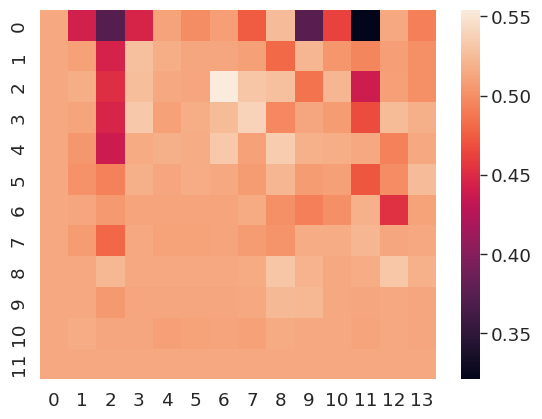

In [57]:
#plot a heat map of the kl divergence
sns.set_style("whitegrid")
sns.set_palette("pastel")
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.heatmap(result.detach().numpy(), annot=False)

In [66]:
import transformer_lens.utils as utils
from tqdm import tqdm

result = torch.zeros(12,14)
pos_input_emb_corrupted = dataset.add_noise(
    model,
    [d["premise"] for d in dataset.pos_dataset],
    noise_index=[1,2,3,9,10,11],
    target_win=8,
    noise_mlt=1.4 
)
pos_clean_logprob = torch.log_softmax(
    model([d["premise"] for d in dataset.pos_dataset]), dim=-1
)[:, -1, :]
LAYER = 0
POS = 0
for LAYER in tqdm(range(12)):
    for POS in range(14):
        # add noise

        def patch_mlp(activation, hook, clean_activation, pos):
            activation[:,pos,:] = clean_activation[:,pos,:]
            return activation
        def patch_attn_output(activation, hook, clean_activation, pos):
            activation[:,pos,:] = clean_activation[:,pos,:]
            return activation
        def embed_hook(cache, hook, input_embeddings):
            cache[:,:,:] = input_embeddings
            return cache

        # hook_fn = partial(patch_mlp, clean_activation=pos_clean_cache[utils.get_act_name("mlp_out",LAYER)], pos=POS)
        hook_fn = partial(patch_attn_output, clean_activation=pos_clean_cache[utils.get_act_name("mlp_out",LAYER)], pos=POS)
        hook_embed = partial(embed_hook, input_embeddings=pos_input_emb_corrupted)

        pos_patched_logit_significant = model.run_with_hooks([d["premise"] for d in dataset.pos_dataset],
                            fwd_hooks=[(utils.get_act_name("mlp_out",LAYER), hook_fn), ("hook_embed", hook_embed)])



        pos_patched_logprob_significant = torch.log_softmax(pos_patched_logit_significant, dim=-1)[:, -1, :]



        pos_patched_logprob_target_significant = pos_patched_logprob_significant.gather(-1, index=pos_target_ids["target"]).squeeze(-1)
        pos_clean_logprob_target = pos_clean_logprob.gather(-1, index=pos_target_ids["target"]).squeeze(-1)
        result[LAYER][POS] = torch.nn.functional.kl_div( pos_patched_logprob_significant, pos_clean_logprob, reduction="batchmean", log_target=True)

100%|██████████| 12/12 [00:50<00:00,  4.22s/it]


<Axes: >

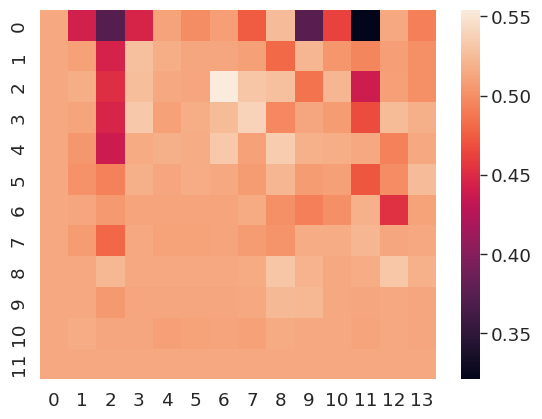

In [67]:
#plot a heat map of the kl divergence
sns.set_style("whitegrid")
sns.set_palette("pastel")
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.heatmap(result.detach().numpy(), annot=False)

<Axes: >

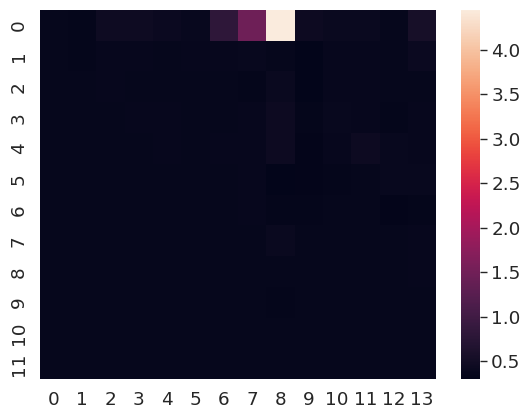

In [65]:
#plot a heat map of the kl divergence
sns.set_style("whitegrid")
sns.set_palette("pastel")
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.heatmap(result.detach().numpy(), annot=False)

<Axes: >

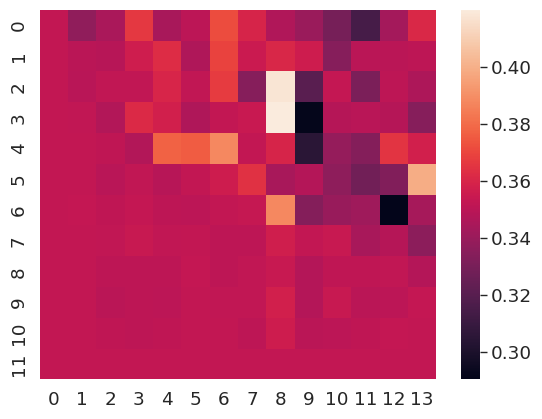

In [62]:
#plot a heat map of the kl divergence
sns.set_style("whitegrid")
sns.set_palette("pastel")
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.heatmap(result.detach().numpy(), annot=False)

## Variance in the patched for negative example

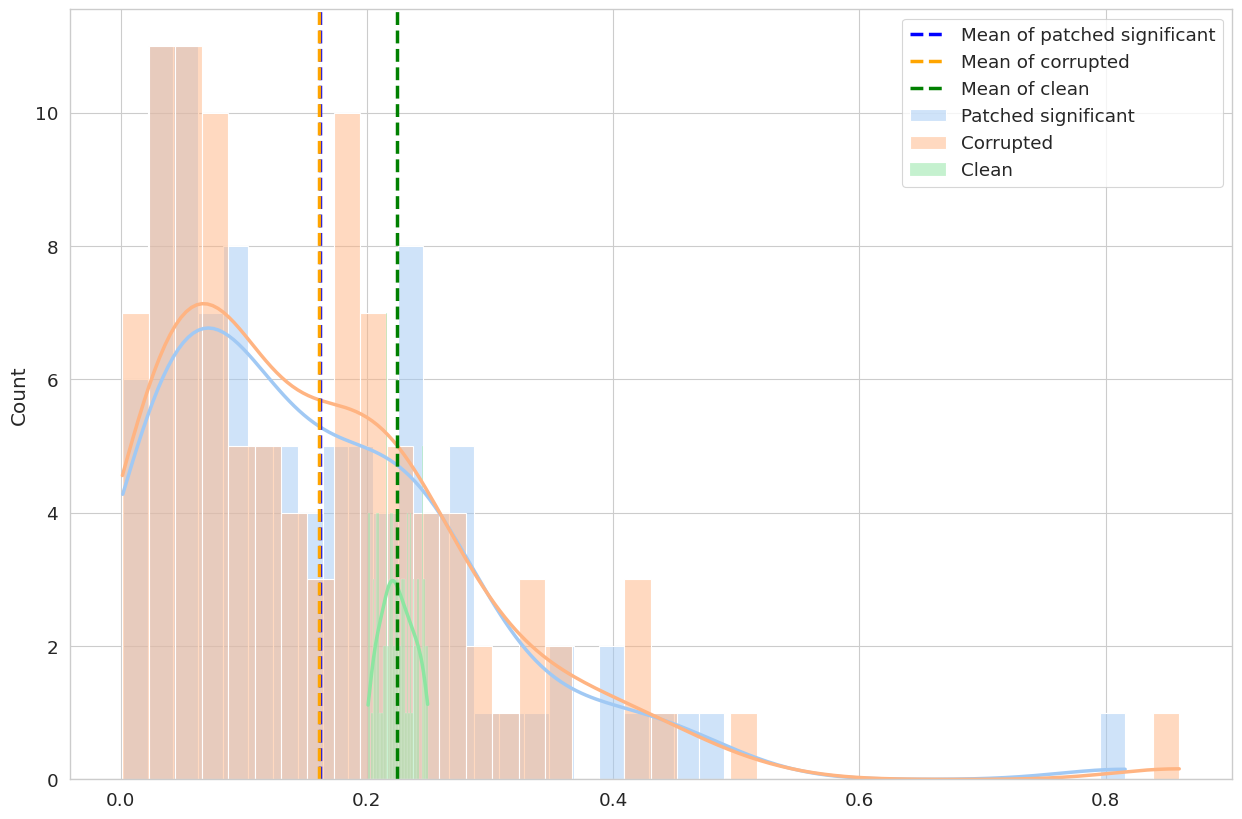

<Axes: ylabel='Count'>

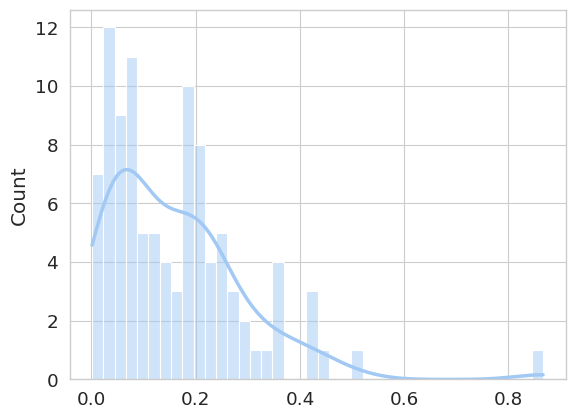

In [8]:
LAYER = 5
POS = 7

# add noise
neg_input_emb_corrupted = dataset.add_noise(
    model,
    [d["premise"] for d in dataset.neg_dataset],
    noise_index=[1,2,3,8,9,10,11],
    target_win=8,
    noise_mlt=0.8
)

import transformer_lens.utils as utils
def patch_mlp(activation, hook, clean_activation, pos):
    activation[:,pos,:] = clean_activation[:,pos,:]
    return activation
def patch_attn_output(activation, hook, clean_activation, pos):
    activation[:,pos,:] = clean_activation[:,pos,:]
    return activation
def embed_hook(cache, hook, input_embeddings):
    cache[:,:,:] = input_embeddings
    return cache

hook_fn = partial(patch_mlp, clean_activation=pos_clean_cache[utils.get_act_name("mlp_out",LAYER)], pos=POS)
# hook_fn = partial(patch_attn_output, clean_activation=neg_clean_cache[utils.get_act_name("attn_out",LAYER)], pos=POS)
hook_embed = partial(embed_hook, input_embeddings=neg_input_emb_corrupted)

neg_patched_logit_significant = model.run_with_hooks([d["premise"] for d in dataset.pos_dataset],
                     fwd_hooks=[(utils.get_act_name("mlp_out",LAYER), hook_fn), ("hook_embed", hook_embed)])


hook_fn = partial(patch_mlp, clean_activation=neg_clean_cache[utils.get_act_name("mlp_out",LAYER)], pos=6)

neg_patched_logit_non_significant = model.run_with_hooks([d["premise"] for d in dataset.neg_dataset],
                     fwd_hooks=[(utils.get_act_name("mlp_out",LAYER), hook_fn), ("hook_embed", hook_embed)])



neg_patched_logprob_significant = torch.softmax(neg_patched_logit_significant, dim=-1)[:, -1, :]
neg_patched_logit_non_significant = torch.softmax(neg_patched_logit_non_significant, dim=-1)[:, -1, :]
neg_clean_logprob = torch.softmax(
    model([d["premise"] for d in dataset.neg_dataset]), dim=-1
)[:, -1, :]
neg_corrupted_logprobs = torch.softmax(
    model.run_with_hooks(
        [d["premise"] for d in dataset.neg_dataset],
        fwd_hooks=[("hook_embed", hook_embed)],
    ), dim=-1
)[:,-1,:]

neg_patched_logprob_target_significant = neg_patched_logprob_significant.gather(-1, index=neg_target_ids["orthogonal"]).squeeze(-1)
neg_patched_logit_non_significant = neg_patched_logit_non_significant.gather(-1, index=neg_target_ids["orthogonal"]).squeeze(-1)
neg_clean_logprob_target = neg_clean_logprob.gather(-1, index=neg_target_ids["orthogonal"]).squeeze(-1)
neg_corrupted_logprobs_target = neg_corrupted_logprobs.gather(-1, index=neg_target_ids["orthogonal"]).squeeze(-1)

# plot the distribution of logprob for target token and orthogonal token

sns.set_style("whitegrid")
sns.set_palette("pastel")
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})
# increase the size of the plot
plt.figure(figsize=(15, 10))
sns.histplot(
    neg_patched_logprob_target_significant.detach().numpy(), bins=40, label="Patched significant", kde=True
)

sns.histplot(neg_corrupted_logprobs_target.detach().numpy(), bins=40, label="Corrupted", kde=True)
sns.histplot(    neg_clean_logprob_target.detach().numpy(), bins=40, label="Clean", kde=True)
#plot the mean of target_win_prob
plt.axvline(x=sum(neg_patched_logprob_target_significant.detach().numpy())/len(neg_patched_logprob_target_significant.detach().numpy()), color="blue", linestyle="--", label="Mean of patched significant")
plt.axvline(x=sum(neg_corrupted_logprobs_target.detach().numpy())/len(neg_corrupted_logprobs_target.detach().numpy()), color="orange", linestyle="--", label="Mean of corrupted")
plt.axvline(x=sum(neg_clean_logprob_target.detach().numpy())/len(neg_clean_logprob_target.detach().numpy()), color="green", linestyle="--", label="Mean of clean")
#plot std deviation in grey area for neg_patched_logprob_target_significant
# plt.axvspan(sum(neg_patched_logprob_target_significant.detach().numpy())/len(neg_patched_logprob_target_significant.detach().numpy())-neg_patched_logprob_target_significant.std().detach().numpy(), sum(neg_patched_logprob_target_significant.detach().numpy())/len(neg_patched_logprob_target_significant.detach().numpy())+neg_patched_logprob_target_significant.std().detach().numpy(), alpha=0.5, color='grey')
# plot median absolut deviation
mad = torch.median(torch.abs(neg_patched_logprob_target_significant - torch.median(neg_patched_logprob_target_significant))) 
# plt.axvspan(sum(pos_patched_logprob_target_significant.detach().numpy())/len(pos_patched_logprob_target_significant.detach().numpy())-mad.detach().numpy(), sum(pos_patched_logprob_target_significant.detach().numpy())/len(pos_patched_logprob_target_significant.detach().numpy())+mad.detach().numpy(), alpha=0.5, color='grey')

print 
sns.histplot()
plt.legend()
plt.show()
sns.set_style("whitegrid")
sns.set_palette("pastel")
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.histplot(neg_patched_logit_non_significant.detach().numpy(), bins=40, label="Patched non-significant", kde=True)

In [9]:
neg_corrupted_logprobs_target.mean()

tensor(0.1610)

tensor(0.0343) tensor(0.1323)
tensor(0.0736) tensor(0.1219)


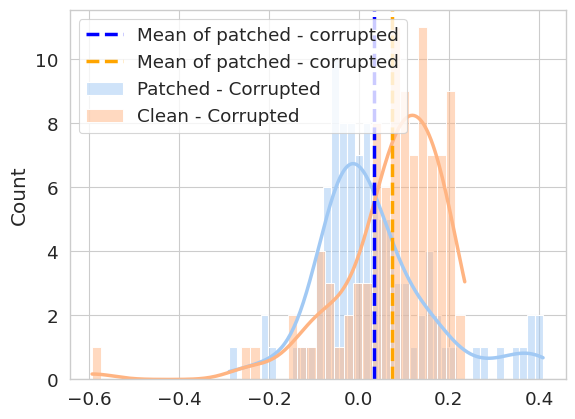

In [72]:



neg_patched_improve = neg_patched_logprob_target_significant - neg_corrupted_logprobs_target
neg_baseline = neg_clean_logprob_target - neg_corrupted_logprobs_target

#plot the distribution of logprob for target token and orthogonal token
sns.set_style("whitegrid")
sns.set_palette("pastel")
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.histplot(neg_patched_improve.detach().numpy(), bins=40, label="Patched - Corrupted", kde=True)
sns.histplot(neg_baseline.detach().numpy(), bins=40, label="Clean - Corrupted", kde=True)
#plot the mean of target_win_prob
plt.axvline(x=sum(neg_patched_improve.detach().numpy())/len(neg_patched_improve.detach().numpy()), color="blue", linestyle="--", label="Mean of patched - corrupted")
plt.axvline(x=sum(neg_baseline.detach().numpy())/len(neg_baseline.detach().numpy()), color="orange", linestyle="--", label="Mean of patched - corrupted")

plt.legend()
print(neg_patched_improve.mean(), neg_patched_improve.std())
print(neg_baseline.mean(), neg_baseline.std())

In [74]:
from scipy.stats import ttest_1samp
ttest_1samp(neg_patched_improve,0)

TtestResult(statistic=2.590611720432074, pvalue=0.011026508485485486, df=99)

In [75]:
ttest_1samp(neg_patched_improve,0)[0]

2.590611720432074

## Noise investigation

Variance of distance:  4.659379


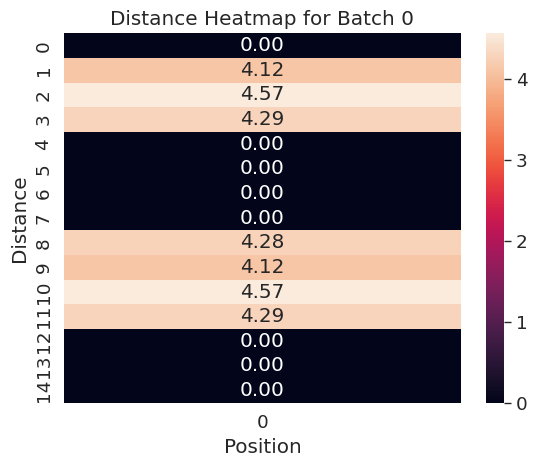

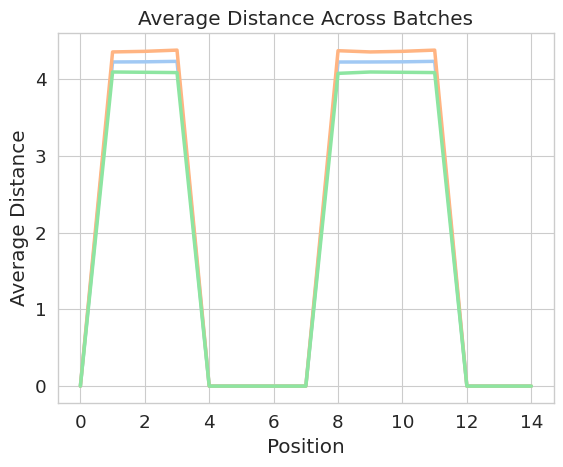

In [59]:
pos_input_emb_corrupted, input_embeddings  = dataset.add_noise(
    model,
    [d["premise"] for d in dataset.pos_dataset],
    noise_index=[1, 2, 3, 8, 9, 10, 11],
    target_win=8,
    noise_mlt=1.4
)
distance = torch.norm(input_embeddings - pos_input_emb_corrupted, dim=2)
import matplotlib.pyplot as plt
import seaborn as sns

# Select a batch index, for example, 0
batch_idx = 0

reshaped_distance = distance[batch_idx].view(-1, 1).detach().cpu().numpy()

#print the variance of the distance
print("Variance of distance: ", reshaped_distance.var())

sns.heatmap(reshaped_distance, annot=True, fmt=".2f")
plt.title('Distance Heatmap for Batch {}'.format(batch_idx))
plt.xlabel('Position')
plt.ylabel('Distance')
plt.show()

# Average distance across batches for each position
avg_distance = torch.mean(distance, dim=0)

plt.plot(avg_distance.detach().cpu().numpy())
plt.plot(avg_distance.detach().cpu().numpy()+torch.std(distance, dim=0).detach().cpu().numpy())
plt.plot(avg_distance.detach().cpu().numpy()-torch.std(distance, dim=0).detach().cpu().numpy())
plt.title('Average Distance Across Batches')
plt.xlabel('Position')
plt.ylabel('Average Distance')
plt.show()



Variance of distance:  0.14821477


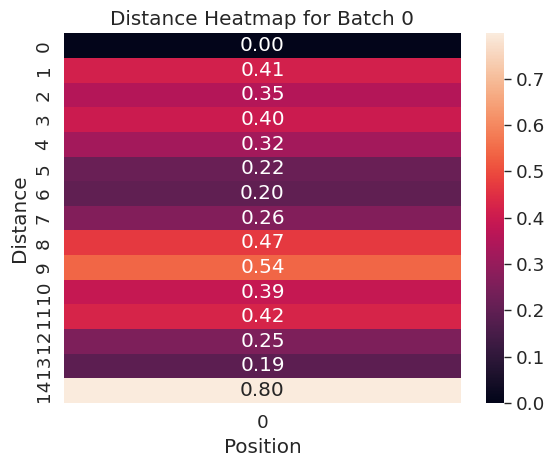

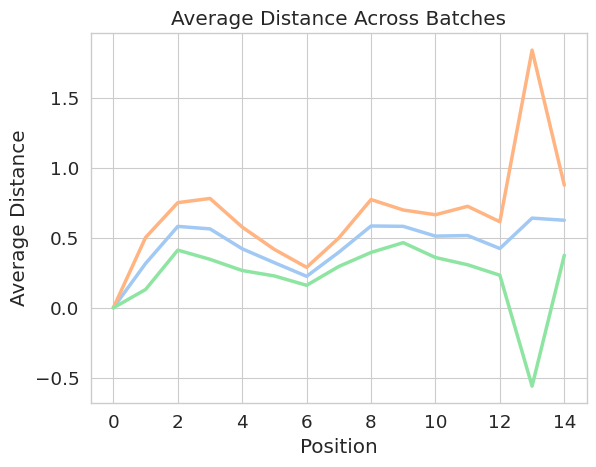

In [58]:
pos_input_emb_corrupted, input_embeddings  = dataset.add_noise(
    model,
    [d["premise"] for d in dataset.pos_dataset],
    noise_index=[1, 2, 3, 8, 9, 10, 11],
    target_win=8,
    noise_mlt=0.01
)
pos_clean_logit, pos_clean_cache = model.run_with_cache([d["premise"] for d in dataset.pos_dataset])
pos_corrupted_logit, pos_corrupted_cache = model.run_with_cache_from_embed(pos_input_emb_corrupted)

pos_out_corrupted_embs = pos_corrupted_cache["blocks.11.hook_resid_post"]
pos_out_embs = pos_clean_cache["blocks.11.hook_resid_post"]
distance = torch.norm(pos_out_embs - pos_out_corrupted_embs, dim=2)
import matplotlib.pyplot as plt
import seaborn as sns

# Select a batch index, for example, 0
batch_idx = 0

reshaped_distance = distance[batch_idx].view(-1, 1).detach().cpu().numpy()

#print the variance of the distance
print("Variance of distance: ", distance.var().detach().numpy())

sns.heatmap(reshaped_distance, annot=True, fmt=".2f")
plt.title('Distance Heatmap for Batch {}'.format(batch_idx))
plt.xlabel('Position')
plt.ylabel('Distance')
plt.show()

# Average distance across batches for each position
avg_distance = torch.mean(distance, dim=0)

plt.plot(avg_distance.detach().cpu().numpy())
# plot the std deviation
plt.plot(avg_distance.detach().cpu().numpy()+torch.std(distance, dim=0).detach().cpu().numpy())
plt.plot(avg_distance.detach().cpu().numpy()-torch.std(distance, dim=0).detach().cpu().numpy())
plt.title('Average Distance Across Batches')
plt.xlabel('Position')
plt.ylabel('Average Distance')
plt.show()


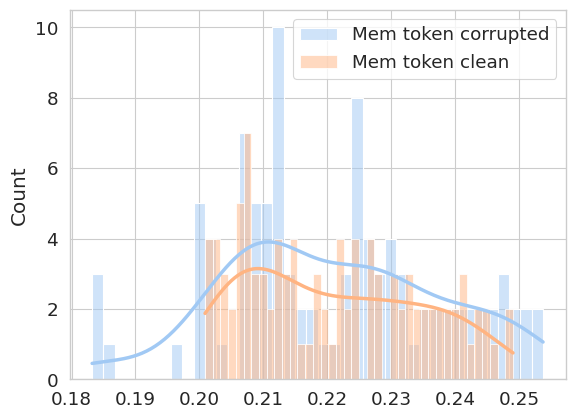

In [32]:
# add noise
pos_input_emb_corrupted = dataset.add_noise(
    model,
    [d["premise"] for d in dataset.pos_dataset],
    noise_index=[1, 2, 3, 8, 9, 10, 11],
    target_win=8,
    noise_mlt=0.01
)
# neg_input_emb_corrupted = dataset.add_noise(
#     model,
#     [d["premise"] for d in dataset.neg_dataset],
#     noise_index=[1, 2, 3, 8, 9, 10, 11],
#     target_win=8,
#     noise_mlt=2
# )
pos_clean_logit, pos_clean_cache = model.run_with_cache([d["premise"] for d in dataset.pos_dataset])
pos_corrupted_logit, pos_corrupted_cache = model.run_with_cache_from_embed(pos_input_emb_corrupted)

# plot distribution of corrupted logits 
pos_corrupted_probs = torch.softmax(pos_corrupted_logit, dim=-1)[:,-1,:]
pos_clean_probs = torch.softmax(pos_clean_logit, dim=-1)[:, -1, :]
# extract the prob for the target token and orthogonal token
pos_target_probs = pos_corrupted_probs.gather(-1, index=pos_target_ids["target"]).squeeze(-1)
pos_target_probs_clean = pos_clean_probs.gather(-1, index=pos_target_ids["target"]).squeeze(-1)
# neg_corrupted_probs = torch.log_softmax(neg_corrupted_logit, dim=-1)[:, -1, :]
sns.set_style("whitegrid")
sns.set_palette("pastel")
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.histplot(pos_target_probs.detach().numpy(), bins=40, label="Mem token corrupted", kde=True)
sns.histplot(pos_target_probs_clean.detach().numpy(), bins=40, label="Mem token clean", kde=True)
plt.legend()

## DEBUG